# Robomed

In [1]:
%matplotlib inline

import re
import numpy as np
import pandas as pd

from sklearn.cluster import KMeans
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin

## Args

In [2]:
TRAIN_PATH = '~/.kaggle/competitions/ai-hack-2018-spb-robomed/train_data.csv'
TEST_PATH = '~/.kaggle/competitions/ai-hack-2018-spb-robomed/test_data.csv'
SUBMISSION_PATH = 'submission.csv'
MODEL_SAVE_PATH = 'model.pkl'

## Read

In [3]:
def initial_pre(df):
    df = df.copy()
    del df['ID']
    rename_map = {
        'Код_диагноза': 'diag_code',
        'Диагноз': 'diag',
        'Возраст': 'age',
        'Пол': 'sex',
        'Общее состояние': 'state',
        'аллергия': 'allergies',
        'Анамнез заболевания': 'anamnesis',
        'Внешний осмотр': 'checkup',
        'Revisit': 'revisit'
    }
    return df.rename(columns=rename_map)

In [4]:
%time df = initial_pre(pd.read_csv(TRAIN_PATH))
len(df)

CPU times: user 1.65 s, sys: 96 ms, total: 1.75 s
Wall time: 1.75 s


283086

In [5]:
df.head()

,diag_code,diag,age,sex,state,allergies,anamnesis,checkup,revisit
0,J06.0,Острый ларингофарингит,29,2,NaN,NaN,NaN,На жевательной поверхности 2.6- кариозная поло...,1
1,N76.1,Подострый и хронический вагинит,45,2,NaN,NaN,считает себя больной на протяжении многих лет....,NaN,1
2,L23.9,"Аллергический контактный дерматит, причина не ...",63,2,NaN,NaN,"Болен около 2-х дней, когда появились описанны...",NaN,1
3,N48.1,Баланопостит,43,2,NaN,не отягощен,NaN,NaN,1
4,Z00.0,Общий медицинский осмотр,29,1,NaN,NaN,провела полное обследование для оперативного л...,NaN,1


In [6]:
df.describe(include='all')

,diag_code,diag,age,sex,state,allergies,anamnesis,checkup,revisit
count,283086,283086,283086.000000,283086.000000,41696,40908,203656,13295,283086.000000
unique,3437,3394,NaN,NaN,2942,5141,152589,779,NaN
top,N77.1*,"Вагинит, вульвит и вульвовагинит при инфекцион...",NaN,NaN,Общее самочувствие удовлетворительное. Кожные ...,не отягощен,консультация по проведенному обследованию и ко...,удовлетворительное.,NaN
freq,11214,11214,NaN,NaN,8960,17361,3025,6622,NaN
mean,NaN,NaN,41.696905,1.708347,NaN,NaN,NaN,NaN,0.828639
std,NaN,NaN,21.540704,0.454524,NaN,NaN,NaN,NaN,0.376825
min,NaN,NaN,1.000000,1.000000,NaN,NaN,NaN,NaN,0.000000
25%,NaN,NaN,31.000000,1.000000,NaN,NaN,NaN,NaN,1.000000
50%,NaN,NaN,38.000000,2.000000,NaN,NaN,NaN,NaN,1.000000
75%,NaN,NaN,51.000000,2.000000,NaN,NaN,NaN,NaN,1.000000


In [7]:
df.dtypes

diag_code    object
diag         object
age           int64
sex           int64
state        object
allergies    object
anamnesis    object
checkup      object
revisit       int64
dtype: object

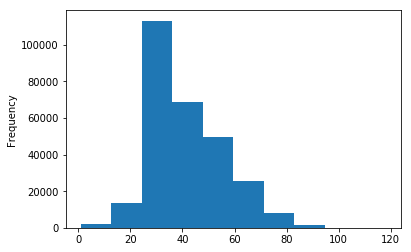

In [8]:
age = df.age.copy()
age[age > 120] = None
age.plot('hist');

## Preprocess

### Only `anamnesis`

In [9]:
# def make_textclf_data(df, balance=False):
#     X, y = df.anamnesis.fillna(''), df.revisit
    
#     if balance:
#         n = y.value_counts().min()
#         y0, y1 = y[y == 0].sample(n), y[y == 1].sample(n)
#         X0, X1 = X[y0.index], X[y1.index]
#         X, y = pd.concat([X0, X1], axis=0).sample(frac=1), pd.concat([y0, y1], axis=0).sample(frac=1)
    
#     return X, y

### Features

In [10]:
def parse_diag_code(diag_code, 
                    dc_pattern=re.compile('([A-Z])?([0-9][0-9])?(\.([0-9]))?')):
    m = dc_pattern.match(diag_code)
    letter, code, subcode = m.group(1), m.group(2), m.group(4)
    code = int(code) if code is not None else None
    subcode = int(subcode) if subcode is not None else None
    return letter, code, subcode


# def get_age_group(age):
#     if age > 120:
#         return None
# #     df.age.as_matrix()[:, np.newaxis].shape
#     return 0

In [11]:
class FFTransformer(BaseEstimator, TransformerMixin):
    def fit(self, df):
        return self
    
    def transform(self, df):
        df = df.copy()
    
        features = []
        # diag_code
        features.append(pd.DataFrame(list(df.diag_code.apply(parse_diag_code)), 
                                     columns=['letter', 'code', 'subcode'],
                                     dtype=object).head())
        # diag
        features.append(df[['diag']])

        # age
        df.loc[df.age > 120, 'age'] = None
        features.append(df[['age']].astype(float))

        # sex
        features.append(df[['sex']])

        # state, allergies, checkup, -anamnesis
        features.append(df[['state', 'allergies', 'checkup']])

        data = pd.concat(features, axis=1)
        data = data.apply(lambda c: c.fillna('NaN') if (c.dtype == object) else c)
        if 'revisit' in df:
            data = (data, df.revisit)

        return data

In [12]:
ff = FFTransformer()
ff.fit(df)
X, y = ff.transform(df)
X.head()

,letter,code,subcode,diag,age,sex,state,allergies,checkup
0,J,6,0,Острый ларингофарингит,29.0,2,NaN,NaN,На жевательной поверхности 2.6- кариозная поло...
1,N,76,1,Подострый и хронический вагинит,45.0,2,NaN,NaN,NaN
2,L,23,9,"Аллергический контактный дерматит, причина не ...",63.0,2,NaN,NaN,NaN
3,N,48,1,Баланопостит,43.0,2,NaN,не отягощен,NaN
4,Z,0,0,Общий медицинский осмотр,29.0,1,NaN,NaN,NaN


In [13]:
X.dtypes

letter        object
code          object
subcode       object
diag          object
age          float64
sex            int64
state         object
allergies     object
checkup       object
dtype: object

In [14]:
y.dtype

dtype('int64')

## TT split

In [15]:
preprocess = FFTransformer()
X, y = preprocess.fit_transform(df)
cat_features = np.where(X.dtypes != np.float)[0]
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)
tdf = initial_pre(pd.read_csv(TEST_PATH))
X_test = preprocess.transform(tdf)
X_train.shape, X_val.shape, X_test.shape

((226468, 9), (56618, 9), (100000, 9))

## Scipy

In [16]:
# from sklearn.pipeline import Pipeline
# from sklearn.linear_model import SGDClassifier
# from sklearn.neural_network import MLPClassifier
# from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [17]:
# model = Pipeline([
#     ('vec', TfidfVectorizer(ngram_range=(1, 3), max_features=1000)),
#     ('clf', MLPClassifier(hidden_layer_sizes=(300, 300, 2))),
#  ])

In [18]:
# %time model.fit(X_train, y_train)

In [19]:
# y_pred = model.predict(X_test)
# (y_pred == y_test).sum() / len(y_test)

In [20]:
# roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])

## Keras

https://gist.github.com/madrugado/63c068b52a135c6fdbbb6fe17acbc0c8

In [21]:
# from keras.preprocessing.text import Tokenizer

In [22]:
# tokenizer = Tokenizer(num_words=1000)
# tokenizer.fit_on_texts(X_train)

In [23]:
# X_train = tokenizer.texts_to_matrix(X_train, mode='binary')
# X_test = tokenizer.texts_to_matrix(X_test, mode='binary')
# X_train.shape, X_test.shape

## CatBoost

https://tech.yandex.com/catboost/doc/dg/concepts/parameter-tuning-docpage/

In [24]:
import catboost as cb

In [25]:
model = cb.CatBoostClassifier()
model.fit(X_train, y_train, cat_features=cat_features, 
          use_best_model=True, eval_set=(X_val, y_val), 
          plot=False);

0:	learn: 0.6769145	test: 0.6767901	best: 0.6767901 (0)	total: 210ms	remaining: 3m 29s
1:	learn: 0.6617739	test: 0.6615406	best: 0.6615406 (1)	total: 374ms	remaining: 3m 6s
2:	learn: 0.6476416	test: 0.6472943	best: 0.6472943 (2)	total: 548ms	remaining: 3m 2s
3:	learn: 0.6344316	test: 0.6339883	best: 0.6339883 (3)	total: 688ms	remaining: 2m 51s
4:	learn: 0.6221070	test: 0.6215614	best: 0.6215614 (4)	total: 826ms	remaining: 2m 44s
5:	learn: 0.6106149	test: 0.6099727	best: 0.6099727 (5)	total: 964ms	remaining: 2m 39s
6:	learn: 0.5998789	test: 0.5991594	best: 0.5991594 (6)	total: 1.11s	remaining: 2m 37s
7:	learn: 0.5898839	test: 0.5890810	best: 0.5890810 (7)	total: 1.24s	remaining: 2m 33s
8:	learn: 0.5805619	test: 0.5796831	best: 0.5796831 (8)	total: 1.4s	remaining: 2m 33s
9:	learn: 0.5718763	test: 0.5709192	best: 0.5709192 (9)	total: 1.53s	remaining: 2m 31s
10:	learn: 0.5637621	test: 0.5627288	best: 0.5627288 (10)	total: 1.69s	remaining: 2m 31s
11:	learn: 0.5561941	test: 0.5550940	best: 0

93:	learn: 0.4178893	test: 0.4137647	best: 0.4137647 (93)	total: 11.3s	remaining: 1m 49s
94:	learn: 0.4177811	test: 0.4136622	best: 0.4136622 (94)	total: 11.4s	remaining: 1m 48s
95:	learn: 0.4176680	test: 0.4135447	best: 0.4135447 (95)	total: 11.5s	remaining: 1m 48s
96:	learn: 0.4176108	test: 0.4134821	best: 0.4134821 (96)	total: 11.6s	remaining: 1m 48s
97:	learn: 0.4175170	test: 0.4133858	best: 0.4133858 (97)	total: 11.7s	remaining: 1m 47s
98:	learn: 0.4174454	test: 0.4133035	best: 0.4133035 (98)	total: 11.8s	remaining: 1m 47s
99:	learn: 0.4173353	test: 0.4131978	best: 0.4131978 (99)	total: 12s	remaining: 1m 47s
100:	learn: 0.4172640	test: 0.4131266	best: 0.4131266 (100)	total: 12s	remaining: 1m 47s
101:	learn: 0.4171733	test: 0.4130268	best: 0.4130268 (101)	total: 12.2s	remaining: 1m 46s
102:	learn: 0.4171137	test: 0.4129558	best: 0.4129558 (102)	total: 12.3s	remaining: 1m 47s
103:	learn: 0.4170312	test: 0.4128641	best: 0.4128641 (103)	total: 12.4s	remaining: 1m 46s
104:	learn: 0.416

184:	learn: 0.4144049	test: 0.4102059	best: 0.4102059 (184)	total: 22.8s	remaining: 1m 40s
185:	learn: 0.4143901	test: 0.4101946	best: 0.4101946 (185)	total: 23s	remaining: 1m 40s
186:	learn: 0.4143790	test: 0.4101842	best: 0.4101842 (186)	total: 23.1s	remaining: 1m 40s
187:	learn: 0.4143688	test: 0.4101741	best: 0.4101741 (187)	total: 23.3s	remaining: 1m 40s
188:	learn: 0.4143600	test: 0.4101688	best: 0.4101688 (188)	total: 23.4s	remaining: 1m 40s
189:	learn: 0.4143545	test: 0.4101645	best: 0.4101645 (189)	total: 23.6s	remaining: 1m 40s
190:	learn: 0.4143459	test: 0.4101572	best: 0.4101572 (190)	total: 23.7s	remaining: 1m 40s
191:	learn: 0.4143429	test: 0.4101574	best: 0.4101572 (190)	total: 23.8s	remaining: 1m 40s
192:	learn: 0.4143133	test: 0.4101303	best: 0.4101303 (192)	total: 24s	remaining: 1m 40s
193:	learn: 0.4143087	test: 0.4101266	best: 0.4101266 (193)	total: 24.1s	remaining: 1m 40s
194:	learn: 0.4142997	test: 0.4101186	best: 0.4101186 (194)	total: 24.3s	remaining: 1m 40s
195

276:	learn: 0.4134682	test: 0.4095386	best: 0.4095386 (276)	total: 35.9s	remaining: 1m 33s
277:	learn: 0.4134613	test: 0.4095309	best: 0.4095309 (277)	total: 36.1s	remaining: 1m 33s
278:	learn: 0.4134475	test: 0.4095116	best: 0.4095116 (278)	total: 36.3s	remaining: 1m 33s
279:	learn: 0.4134444	test: 0.4095087	best: 0.4095087 (279)	total: 36.4s	remaining: 1m 33s
280:	learn: 0.4134230	test: 0.4095028	best: 0.4095028 (280)	total: 36.6s	remaining: 1m 33s
281:	learn: 0.4134117	test: 0.4095018	best: 0.4095018 (281)	total: 36.7s	remaining: 1m 33s
282:	learn: 0.4134072	test: 0.4095021	best: 0.4095018 (281)	total: 36.8s	remaining: 1m 33s
283:	learn: 0.4134033	test: 0.4094987	best: 0.4094987 (283)	total: 37s	remaining: 1m 33s
284:	learn: 0.4134003	test: 0.4094994	best: 0.4094987 (283)	total: 37.1s	remaining: 1m 33s
285:	learn: 0.4133928	test: 0.4094954	best: 0.4094954 (285)	total: 37.2s	remaining: 1m 32s
286:	learn: 0.4133834	test: 0.4094886	best: 0.4094886 (286)	total: 37.4s	remaining: 1m 32s
2

368:	learn: 0.4128392	test: 0.4092260	best: 0.4092260 (368)	total: 49.4s	remaining: 1m 24s
369:	learn: 0.4128280	test: 0.4092202	best: 0.4092202 (369)	total: 49.5s	remaining: 1m 24s
370:	learn: 0.4128236	test: 0.4092194	best: 0.4092194 (370)	total: 49.7s	remaining: 1m 24s
371:	learn: 0.4128195	test: 0.4092194	best: 0.4092194 (370)	total: 49.8s	remaining: 1m 24s
372:	learn: 0.4128107	test: 0.4092189	best: 0.4092189 (372)	total: 50s	remaining: 1m 24s
373:	learn: 0.4128039	test: 0.4092113	best: 0.4092113 (373)	total: 50.2s	remaining: 1m 23s
374:	learn: 0.4128014	test: 0.4092121	best: 0.4092113 (373)	total: 50.3s	remaining: 1m 23s
375:	learn: 0.4127970	test: 0.4092105	best: 0.4092105 (375)	total: 50.5s	remaining: 1m 23s
376:	learn: 0.4127938	test: 0.4092090	best: 0.4092090 (376)	total: 50.6s	remaining: 1m 23s
377:	learn: 0.4127884	test: 0.4092057	best: 0.4092057 (377)	total: 50.8s	remaining: 1m 23s
378:	learn: 0.4127855	test: 0.4092047	best: 0.4092047 (378)	total: 50.9s	remaining: 1m 23s
3

460:	learn: 0.4123280	test: 0.4090503	best: 0.4090503 (460)	total: 1m 3s	remaining: 1m 13s
461:	learn: 0.4123212	test: 0.4090481	best: 0.4090481 (461)	total: 1m 3s	remaining: 1m 13s
462:	learn: 0.4123187	test: 0.4090474	best: 0.4090474 (462)	total: 1m 3s	remaining: 1m 13s
463:	learn: 0.4123164	test: 0.4090475	best: 0.4090474 (462)	total: 1m 3s	remaining: 1m 13s
464:	learn: 0.4123126	test: 0.4090468	best: 0.4090468 (464)	total: 1m 3s	remaining: 1m 13s
465:	learn: 0.4123110	test: 0.4090454	best: 0.4090454 (465)	total: 1m 3s	remaining: 1m 13s
466:	learn: 0.4123081	test: 0.4090447	best: 0.4090447 (466)	total: 1m 4s	remaining: 1m 13s
467:	learn: 0.4123050	test: 0.4090448	best: 0.4090447 (466)	total: 1m 4s	remaining: 1m 13s
468:	learn: 0.4123002	test: 0.4090410	best: 0.4090410 (468)	total: 1m 4s	remaining: 1m 12s
469:	learn: 0.4122970	test: 0.4090396	best: 0.4090396 (469)	total: 1m 4s	remaining: 1m 12s
470:	learn: 0.4122923	test: 0.4090378	best: 0.4090378 (470)	total: 1m 4s	remaining: 1m 12s

552:	learn: 0.4119372	test: 0.4089237	best: 0.4089224 (551)	total: 1m 17s	remaining: 1m 2s
553:	learn: 0.4119347	test: 0.4089234	best: 0.4089224 (551)	total: 1m 17s	remaining: 1m 2s
554:	learn: 0.4119290	test: 0.4089183	best: 0.4089183 (554)	total: 1m 17s	remaining: 1m 2s
555:	learn: 0.4119256	test: 0.4089200	best: 0.4089183 (554)	total: 1m 17s	remaining: 1m 1s
556:	learn: 0.4119228	test: 0.4089190	best: 0.4089183 (554)	total: 1m 17s	remaining: 1m 1s
557:	learn: 0.4119209	test: 0.4089182	best: 0.4089182 (557)	total: 1m 17s	remaining: 1m 1s
558:	learn: 0.4119180	test: 0.4089195	best: 0.4089182 (557)	total: 1m 17s	remaining: 1m 1s
559:	learn: 0.4119129	test: 0.4089184	best: 0.4089182 (557)	total: 1m 18s	remaining: 1m 1s
560:	learn: 0.4119086	test: 0.4089186	best: 0.4089182 (557)	total: 1m 18s	remaining: 1m 1s
561:	learn: 0.4119009	test: 0.4089189	best: 0.4089182 (557)	total: 1m 18s	remaining: 1m 1s
562:	learn: 0.4118947	test: 0.4089156	best: 0.4089156 (562)	total: 1m 18s	remaining: 1m 1s

644:	learn: 0.4115793	test: 0.4088393	best: 0.4088386 (643)	total: 1m 31s	remaining: 50.2s
645:	learn: 0.4115704	test: 0.4088387	best: 0.4088386 (643)	total: 1m 31s	remaining: 50s
646:	learn: 0.4115609	test: 0.4088339	best: 0.4088339 (646)	total: 1m 31s	remaining: 49.9s
647:	learn: 0.4115575	test: 0.4088327	best: 0.4088327 (647)	total: 1m 31s	remaining: 49.8s
648:	learn: 0.4115552	test: 0.4088323	best: 0.4088323 (648)	total: 1m 31s	remaining: 49.6s
649:	learn: 0.4115537	test: 0.4088315	best: 0.4088315 (649)	total: 1m 31s	remaining: 49.5s
650:	learn: 0.4115513	test: 0.4088321	best: 0.4088315 (649)	total: 1m 32s	remaining: 49.4s
651:	learn: 0.4115468	test: 0.4088302	best: 0.4088302 (651)	total: 1m 32s	remaining: 49.2s
652:	learn: 0.4115410	test: 0.4088305	best: 0.4088302 (651)	total: 1m 32s	remaining: 49.1s
653:	learn: 0.4115402	test: 0.4088305	best: 0.4088302 (651)	total: 1m 32s	remaining: 49s
654:	learn: 0.4115387	test: 0.4088304	best: 0.4088302 (651)	total: 1m 32s	remaining: 48.8s
655

736:	learn: 0.4112338	test: 0.4087341	best: 0.4087325 (735)	total: 1m 45s	remaining: 37.7s
737:	learn: 0.4112263	test: 0.4087292	best: 0.4087292 (737)	total: 1m 45s	remaining: 37.6s
738:	learn: 0.4112226	test: 0.4087272	best: 0.4087272 (738)	total: 1m 45s	remaining: 37.4s
739:	learn: 0.4112198	test: 0.4087281	best: 0.4087272 (738)	total: 1m 46s	remaining: 37.3s
740:	learn: 0.4112173	test: 0.4087247	best: 0.4087247 (740)	total: 1m 46s	remaining: 37.1s
741:	learn: 0.4112158	test: 0.4087242	best: 0.4087242 (741)	total: 1m 46s	remaining: 37s
742:	learn: 0.4112129	test: 0.4087243	best: 0.4087242 (741)	total: 1m 46s	remaining: 36.9s
743:	learn: 0.4112084	test: 0.4087245	best: 0.4087242 (741)	total: 1m 46s	remaining: 36.7s
744:	learn: 0.4112013	test: 0.4087248	best: 0.4087242 (741)	total: 1m 46s	remaining: 36.6s
745:	learn: 0.4111978	test: 0.4087219	best: 0.4087219 (745)	total: 1m 47s	remaining: 36.4s
746:	learn: 0.4111946	test: 0.4087234	best: 0.4087219 (745)	total: 1m 47s	remaining: 36.3s
7

827:	learn: 0.4108639	test: 0.4086156	best: 0.4086156 (827)	total: 2m	remaining: 25s
828:	learn: 0.4108612	test: 0.4086163	best: 0.4086156 (827)	total: 2m	remaining: 24.8s
829:	learn: 0.4108582	test: 0.4086105	best: 0.4086105 (829)	total: 2m	remaining: 24.7s
830:	learn: 0.4108567	test: 0.4086099	best: 0.4086099 (830)	total: 2m	remaining: 24.5s
831:	learn: 0.4108536	test: 0.4086073	best: 0.4086073 (831)	total: 2m	remaining: 24.4s
832:	learn: 0.4108504	test: 0.4086074	best: 0.4086073 (831)	total: 2m	remaining: 24.2s
833:	learn: 0.4108468	test: 0.4086080	best: 0.4086073 (831)	total: 2m 1s	remaining: 24.1s
834:	learn: 0.4108440	test: 0.4086063	best: 0.4086063 (834)	total: 2m 1s	remaining: 24s
835:	learn: 0.4108416	test: 0.4086045	best: 0.4086045 (835)	total: 2m 1s	remaining: 23.8s
836:	learn: 0.4108380	test: 0.4086017	best: 0.4086017 (836)	total: 2m 1s	remaining: 23.7s
837:	learn: 0.4108327	test: 0.4086010	best: 0.4086010 (837)	total: 2m 1s	remaining: 23.5s
838:	learn: 0.4108269	test: 0.40

919:	learn: 0.4105629	test: 0.4085410	best: 0.4085404 (918)	total: 2m 15s	remaining: 11.8s
920:	learn: 0.4105621	test: 0.4085417	best: 0.4085404 (918)	total: 2m 15s	remaining: 11.6s
921:	learn: 0.4105582	test: 0.4085384	best: 0.4085384 (921)	total: 2m 15s	remaining: 11.5s
922:	learn: 0.4105533	test: 0.4085374	best: 0.4085374 (922)	total: 2m 15s	remaining: 11.3s
923:	learn: 0.4105508	test: 0.4085365	best: 0.4085365 (923)	total: 2m 16s	remaining: 11.2s
924:	learn: 0.4105475	test: 0.4085328	best: 0.4085328 (924)	total: 2m 16s	remaining: 11s
925:	learn: 0.4105402	test: 0.4085340	best: 0.4085328 (924)	total: 2m 16s	remaining: 10.9s
926:	learn: 0.4105380	test: 0.4085351	best: 0.4085328 (924)	total: 2m 16s	remaining: 10.8s
927:	learn: 0.4105367	test: 0.4085348	best: 0.4085328 (924)	total: 2m 16s	remaining: 10.6s
928:	learn: 0.4105335	test: 0.4085333	best: 0.4085328 (924)	total: 2m 16s	remaining: 10.5s
929:	learn: 0.4105297	test: 0.4085330	best: 0.4085328 (924)	total: 2m 16s	remaining: 10.3s
9

In [26]:
roc_auc_score(y_val, model.predict_proba(X_val)[:, 1])

0.7227744684064267

## Submission

In [27]:
sdf = pd.DataFrame(tdf.index, columns=['ID'])
sdf['proba'] = model.predict_proba(X_test)[:, 1]
sdf.head()

,ID,proba
0,0,0.934055
1,1,0.936413
2,2,0.857634
3,3,0.979118
4,4,0.878753


In [28]:
sdf.to_csv(SUBMISSION_PATH, index=False)